## Load the spectrum
- C2H (N=4-3) data (Band 7) in TW Hya from the ALMA Science Archive (2013.1.00198.S; published in Bergin et al. 2016)
- Spectrum is azimuthally aligned and stacked by GoFish and averaged over 0.8"-1.8" radial range

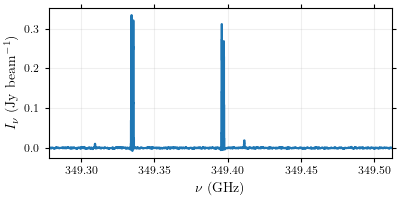

In [7]:
from specfit.core import Spectrum
import specfit.utils as utils
import matplotlib.pyplot as plt
%matplotlib widget

# plot appearance
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "xtick.top": True,
        "ytick.right": True,
        "xtick.direction": "out",
        "ytick.direction": "out",
        "xtick.color": "black",
        "xtick.labelcolor": "black",
        "xtick.labelsize": 8,
        "xtick.major.size": 3.0,
        "ytick.color": "black",
        "ytick.labelcolor": "black",
        "ytick.labelsize": 8,
        "ytick.major.size": 3.0,
    }
)

# TW Hya systemic velocity
vsys = 2.84 # in km/s

filename = "./data/TW_Hya_C2H_4-3_spectrum_stacked_0.8-1.8.h5"
spec = Spectrum(filename=filename)
fig, ax = plt.subplots(figsize=(4, 2), layout="constrained")
spec.plot(ax=ax, axis="freq", error_scaling=0.0, drawstyle="steps-mid")
ax.set(xlabel=r"$\nu$ (GHz)", ylabel=r"$I_\nu$ (Jy beam$^{-1}$)")
ax.grid(alpha=0.2)

# calculate beam solid angle which is used later
spec.Omega_beam = utils.get_beam_solid_angle(beam=spec.beam[:2])

## Retrieve the spectroscopic data 
- ``specfit.specdata`` module can be used to retrieve the spectraoscopic data of specific molecules from data catalog
- currently only CDMS is available but others (e.g., JPL) will be soon available 
- First you have to found the CDMS key for a specific molecule at [here](https://cdms.astro.uni-koeln.de/classic/entries/partition_function.html) and that is used to search for transitions in a specific frequency range

In [8]:
from specfit.specdata import SpectroscopicData
from specfit import utils

species_key = {"C2H": "CCH, v=0"}
nu_rest = utils.unshift_freq(spec.nu, vsys=vsys) # in Hz

data = SpectroscopicData()
data.quely_CDMS(freq_range=(nu_rest.min(), nu_rest.max()), species=species_key["C2H"], nofreqerr=True)

# check by printing the table
print(data.table)

Species   Frequency     A_ul      E_up   g_up  Ju  Ku  vu  Jl  Kl  vl
             GHz       1 / s       K                                 
-------- ----------- ---------- -------- ---- --- --- --- --- --- ---
CCH, v=0 349.3128323 2.9916e-06 41.91376    9   4   5   4   3   4   4
CCH, v=0 349.3377056 1.3077e-04 41.91495   11   4   5   5   3   4   4
CCH, v=0 349.3389882 1.2770e-04 41.91372    9   4   5   4   3   4   3
CCH, v=0 349.3992756 1.2529e-04 41.92769    9   4   4   4   3   3   3
CCH, v=0 349.4006712 1.2017e-04 41.92848    7   4   4   3   3   3   2
CCH, v=0 349.4146425 7.0323e-06 41.92843    7   4   4   3   3   3   3


## Construct the model to fit
- Here you can construct any models to fit to the observed spectra
- As an example, here we use the basic 0D radiative transfer slab model in LTE condition

In [9]:
import numpy as np
from specfit import constants as const
import specfit.core as spf
from scipy.interpolate import interp1d

## Model functions
# frequency resampling width in km/s
dv = 0.01

def thermal_line_width(T, mu):
    return np.sqrt(const.k_B * T / (mu * const.m_p)) * 1e-5  # in km/s


def calc_model(nu, species, paramset, data):
    # frequency resampling
    dnu = utils.dv2dnu_abs(dv, nu.mean())
    nu_resampled = np.arange(nu.min() - dnu, nu.max() + dnu, dnu)
    nu_c = utils.shift_freq(data.nu0, vsys=paramset.v_sys.value)

    # optical depth profile
    sigma_nu = utils.dv2dnu_abs(thermal_line_width(paramset.Tex.value, data.mu), data.nu0)
    # sigma_nu = au.dv2dnu_abs(paramset.sigma_v.value, nu0=data.nu0)
    logN = getattr(paramset, "logN_" + species)
    tau = spf.calc_line_optical_depth(
        nu_resampled,
        nu_c,
        sigma_nu,
        paramset.Tex.value,
        logN.value,
        data.Aul,
        data.gup,
        data.Eup,
        data.Q,
    )

    # intensity
    I = spf.Bnu(nu_resampled, paramset.Tex.value) * (1 - np.exp(-tau))

    # convolve Gaussian
    I = utils.convolve_Gaussian(
        x=nu_resampled, y=I, sigma=utils.dv2dnu_abs(paramset.sigma_v.value, nu_resampled.mean())
    )

    # Jy/sr to K
    # I = au.jypsr_to_K_RJ(I, nu=nu.mean())

    # interpolation to the original frequency axis
    I = interp1d(nu_resampled, I)(nu)
    return I

## Conduct MCMC fit
- Fit the observed spectra by the model above
- A few MCMC wrapper functions based on ``emcee`` package are used here

In [11]:
from specfit.utils import Parameter, ParameterSet, log_prior, EmceeHammer
import multiprocessing
import os
import pickle

# set-up for MCMC fit
species = "C2H"
species_labels = {"C2H": "C$_2$H"}
nwalker = 50
nstep = 1000
nburnin = 500
nprocess = 16
fitdir = "./data/fit/C2H_full/" # directory to save the fit result
run = True # if the fit is actually run; otherwise, just load the fit result saved in "fitdir"

# make fitdir if not exists
if not os.path.exists(fitdir):
    os.makedirs(fitdir)

# set parameter list
param_list = [
    Parameter(
        name="Tex", value=20, bound=(2.73, 50), free=True, label="$T_\mathrm{ex}$ (K)"
    ),
    Parameter(
        name="sigma_v",
        value=0.5,
        bound=(0.01, 5),
        free=True,
        label="$\sigma_v$ (km s$^{-1}$)",
    ),
    Parameter(
        name="v_sys",
        value=2.84,
        bound=(1, 5),
        free=True,
        label="$v_\mathrm{sys}$ (km s$^{-1}$)",
    ),
    Parameter(
        name="logN_" + species,
        value=12.0,
        bound=(10.0, 21.0),
        free=True,
        label=f"log$_{{10}}\,N$(" + species_labels[species] + ") (cm$^{{-2}}$) \n",
    ),
]

paramset = ParameterSet(param_list)


if run:
    # first save the parameterset
    filename = fitdir + "parameters.pkl"
    with open(filename, "wb") as f:
        pickle.dump(paramset, f)

    # likelihood function adopted in emcee
    def log_likelihood(param):
        for name, val in zip(paramset.free_param_name, param):
            getattr(paramset, name).set_value(val)

        I_mod = calc_model(spec.nu, species, paramset, data)
        ll = -0.5 * np.nansum(
            (spec.I - I_mod * spec.Omega_beam) ** 2 / spec.dI**2
        )

        return ll

    # log probability function
    def log_probability(param):
        lp = log_prior(param, paramset.bound)
        if not np.isfinite(lp):
            return -np.inf
        ll = log_likelihood(param)
        return lp + ll

    # start the emcee hammer
    hammer = EmceeHammer(
        log_probability=log_probability,
        initial_state=[
            getattr(paramset, param).value for param in paramset.free_param_name
        ],
        initial_state_blob_mag=1e-4,
        nwalker=nwalker,
        nstep=nstep,
    )

    print(f"Starting to fit the spectrum ...")
    with multiprocessing.Pool(processes=nprocess) as pool:
        hammer.run(
            progress=True,
            save=True,
            savefilename=fitdir + "fit.h5",
            pool=pool
        )
    print(f"Done.")

else:
    hammer = EmceeHammer()
    hammer.load_backend(filename=fitdir + "fit.h5")


Starting to fit the spectrum ...


starting to run the MCMC sampling with: 
 	 initial state: [20.    0.5   2.84 12.  ] 
 	 number of walkers: 50 
 	 number of steps: 1000
Done.


## Check the fit with trace and corner plots

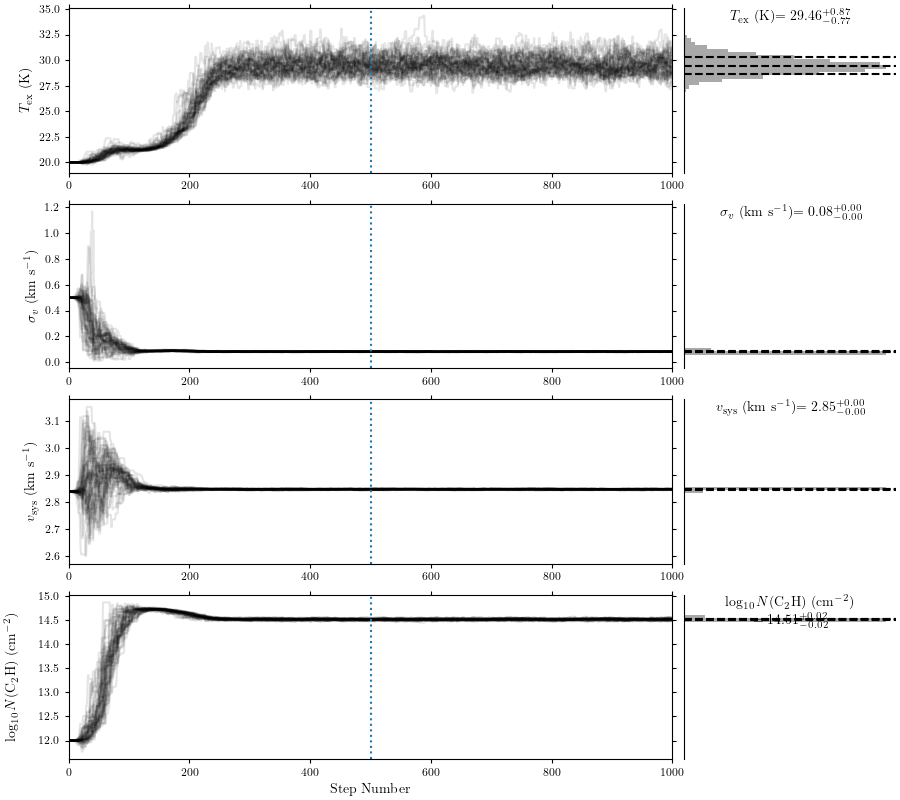

In [12]:
hammer.plot_walker(nburnin=nburnin, labels=paramset.get_free_param_label())

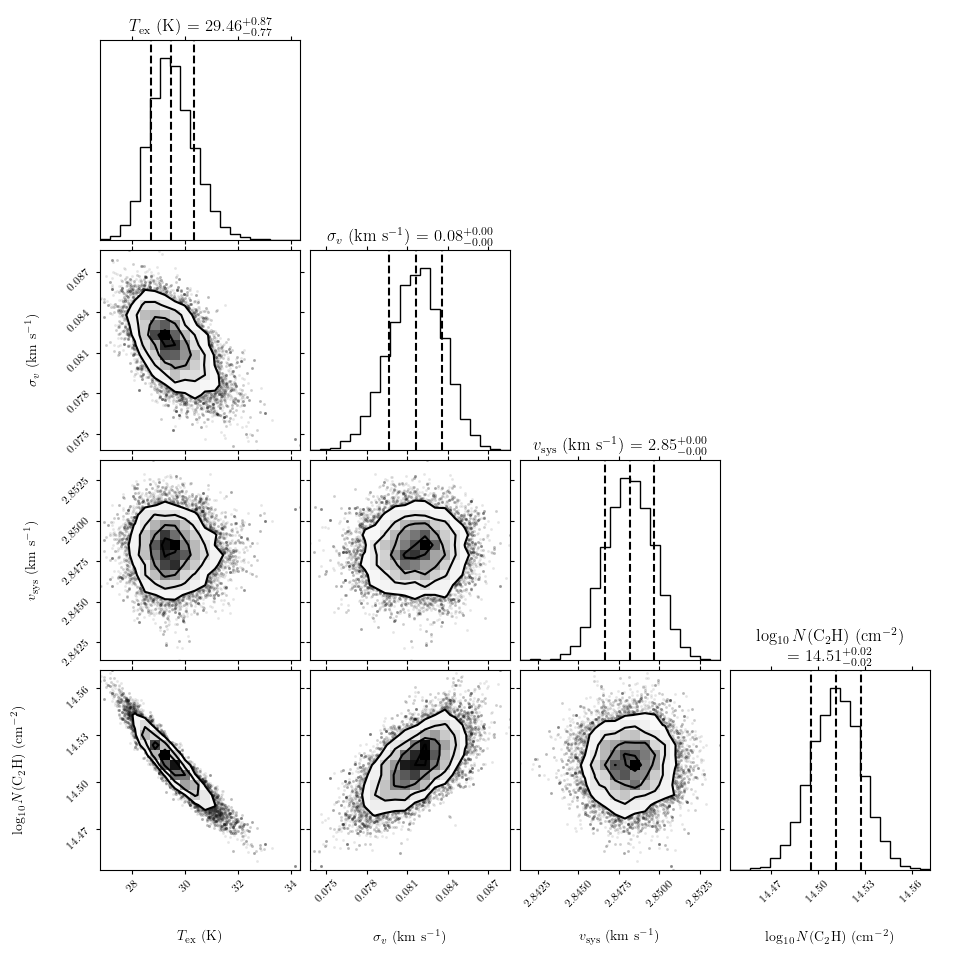

In [13]:
hammer.plot_corner(nburnin=nburnin, labels=paramset.get_free_param_label())

## Check the fit quality
- Plot the observed spectra overlaied with model


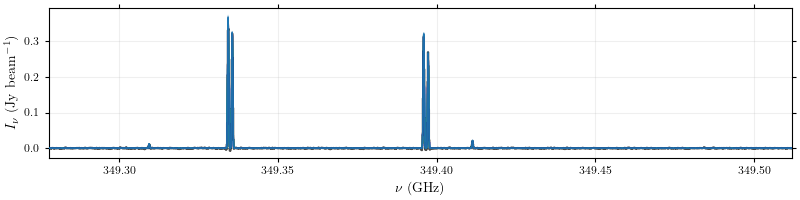

In [14]:
# plot to check
# random number generator for MCMC sample selection
rng = np.random.default_rng(19971206)
nsample = 50
show_error = False

fig, ax = plt.subplots(
    figsize=(8, 2), layout="constrained"
)

ax.errorbar(
    spec.nu * 1e-9,
    spec.I,
    yerr=spec.dI if show_error else None,
    color="0.3",
    drawstyle="steps-mid"
)
ax.axhline(y=0.0, color="gray", lw=1.0, ls="dashed")

sample = hammer.get_flat_sample(nburnin=nburnin)
dnu = utils.dv2dnu_abs(dv, spec.nu.mean())
nu = np.arange(spec.nu.min() - dnu, spec.nu.max() + dnu, dnu)
for j in rng.integers(low=0, high=sample.shape[0], size=nsample):
    for name, val in zip(paramset.free_param_name, sample[j]):
        getattr(paramset, name).set_value(val)

    I_mod = calc_model(nu, species, paramset, data) * spec.Omega_beam

    ax.plot(
        nu * 1e-9,
        I_mod,
        color="tab:blue",
        alpha=0.1,
        lw=1.0,
        zorder=100,
    )

ax.set(
    # xlim=(-11, 19),
    xlim=(spec.nu.min() * 1e-9, spec.nu.max() * 1e-9),
    xlabel=r"$\nu$ (GHz)",
    ylabel=r"$I_\nu$ (Jy beam$^{-1}$)",
)
ax.grid(alpha=0.2);